### Import data

In [40]:
import pandas as pd
import numpy as np
import string
import textblob
import re
import gensim
import json
from collections import defaultdict
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn import preprocessing, model_selection
from sklearn import decomposition
from sklearn.linear_model import SGDClassifier, LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, log_loss
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
%matplotlib inline
# fix random seed for reproducibility
np.random.seed(7)

In [3]:
data_path = 'dataset/new_tableocr_category_0.csv'
df = pd.read_csv(data_path)

In [4]:
df.head()

,item,category
0,3 bedded room,room charges
1,accident & emergency department,room charges
2,admin charges,general procedures
3,administrative charges,general procedures
4,administrative fees,general procedures


### Data pre-processing

In [5]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
df['item'] = df['item'].apply(clean_text)

### Data visualization

In [6]:
df.head()

,item,category
0,3 bedded room,room charges
1,accident emergency department,room charges
2,admin charges,general procedures
3,administrative charges,general procedures
4,administrative fees,general procedures


In [7]:
df.columns

Index(['item', 'category'], dtype='object')

In [8]:
len(df['item'])

1920

In [9]:
df['item'].apply(lambda x: len(x.split(' '))).sum()

4433

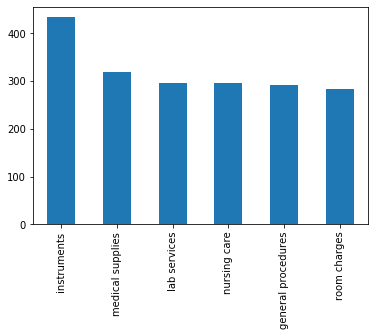

In [10]:
df['category'].value_counts().plot(kind='bar')

### Data split

In [36]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df['item'], 
                                                                      df['category'], 
                                                                      random_state = 7)


# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)
label_name = encoder.inverse_transform(train_y)

array(['instruments', 'room charges', 'instruments', ..., 'lab services',
       'room charges', 'nursing care'], dtype=object)

#### index class mapping

In [57]:
index_label = defaultdict(str)
for i,j in zip(train_y, label_name):
    if not index_label[str(i)]:
        index_label[str(i)] = j
index_label

defaultdict(str,
            {'1': 'instruments',
             '5': 'room charges',
             '4': 'nursing care',
             '3': 'medical supplies',
             '0': 'general procedures',
             '2': 'lab services'})

#### save index_label_mapping to json

In [60]:
index_label_mapping = 'index_label.json'

with open(index_label_mapping, 'w') as savefile:
    json.dump(index_label, savefile)
    
with open(index_label_mapping) as json_file:
    index_label = json.load(json_file)
    
index_label

{'1': 'instruments',
 '5': 'room charges',
 '4': 'nursing care',
 '3': 'medical supplies',
 '0': 'general procedures',
 '2': 'lab services'}

##### Feature transformation

In [13]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', stop_words="english", token_pattern=r'\w{1,}')
count_vect.fit(df['item'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

In [14]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word',
                             stop_words="english",
                             token_pattern=r'\w{1,}', 
                             max_features=5000)
tfidf_vect.fit(df['item'])
xtrain_tfidf = tfidf_vect.transform(train_x)
xvalid_tfidf = tfidf_vect.transform(valid_x)

In [15]:
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', 
                                   stop_words="english",
                                   token_pattern=r'\w{1,}', 
                                   ngram_range=(2,3), 
                                   max_features=5000)
tfidf_vect_ngram.fit(df['item'])
xtrain_tfidf_ngram =tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram = tfidf_vect_ngram.transform(valid_x)

In [16]:
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', 
                                         stop_words="english",
                                         token_pattern=r'\w{1,}', 
                                         ngram_range=(2,3), 
                                         max_features=5000)
tfidf_vect_ngram_chars.fit(df['item'])
xtrain_tfidf_ngram_chars = tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars = tfidf_vect_ngram_chars.transform(valid_x) 

### Build and train models

In [17]:
def train_model(classifier, 
                feature_vector_train, 
                label, 
                feature_vector_valid, 
                is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return accuracy_score(predictions, valid_y)

Naive Bayes

In [18]:
# Naive Bayes on Count Vectors
accuracy = train_model(MultinomialNB(), 
                       xtrain_count, 
                       train_y, 
                       xvalid_count)
print ("NB Count Vectors: ", accuracy)

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(MultinomialNB(), 
                       xtrain_tfidf, 
                       train_y, 
                       xvalid_tfidf)
print ("NB accuracy with WordLevel TF-IDF: ", accuracy)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy = train_model(MultinomialNB(), 
                       xtrain_tfidf_ngram, 
                       train_y, 
                       xvalid_tfidf_ngram)
print ("NB accuracy with N-Gram Vectors: ", accuracy)

# Naive Bayes on Character Level TF IDF Vectors
accuracy = train_model(MultinomialNB(), 
                       xtrain_tfidf_ngram_chars, 
                       train_y, 
                       xvalid_tfidf_ngram_chars)
print ("NB accuracy with CharLevel Vectors: ", accuracy)

NB Count Vectors:  0.85
NB accuracy with WordLevel TF-IDF:  0.8583333333333333
NB accuracy with N-Gram Vectors:  0.3875
NB accuracy with CharLevel Vectors:  0.8833333333333333


In [19]:
nb = Pipeline([('vect', CountVectorizer(max_df=0.95)),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

logreg = LogisticRegression()
clf = GridSearchCV(nb, param_grid = {}, cv=5, refit=True)

clf.fit(train_x, train_y)
y_pred = clf.predict(valid_x)

print('accuracy %s' % accuracy_score(valid_y, y_pred))
print(classification_report(valid_y, y_pred))

accuracy 0.8604166666666667
              precision    recall  f1-score   support

           0       0.92      0.93      0.92        70
           1       0.70      0.95      0.80       112
           2       0.93      0.82      0.87        68
           3       0.98      0.60      0.74        94
           4       0.88      0.96      0.92        69
           5       0.98      0.96      0.97        67

    accuracy                           0.86       480
   macro avg       0.90      0.87      0.87       480
weighted avg       0.88      0.86      0.86       480



In [61]:
sample = 'charges'
result_index = clf.predict([sample])[0]
result = index_label[str(result_index)]
result

'general procedures'

## SGD model

In [29]:
sgd = Pipeline([('vect', CountVectorizer(max_df=0.95)),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', 
                                      class_weight='balanced',
                                                   penalty='l2',
                                                   alpha=1e-3, 
                                                   random_state=7, 
                                                   max_iter=20, 
                                                   tol=None))])
sgd.fit(train_x, train_y)
y_pred = sgd.predict(valid_x)

print('accuracy %s' % accuracy_score(valid_y, y_pred))
print(classification_report(valid_y, y_pred))

accuracy 0.9
              precision    recall  f1-score   support

           0       0.97      0.93      0.95        70
           1       0.92      0.84      0.88       112
           2       0.88      0.84      0.86        68
           3       0.79      0.90      0.84        94
           4       0.92      0.96      0.94        69
           5       0.98      0.97      0.98        67

    accuracy                           0.90       480
   macro avg       0.91      0.91      0.91       480
weighted avg       0.90      0.90      0.90       480



In [62]:
sample = 'nursing c'
result_index = sgd.predict([sample])[0]
result = index_label[str(result_index)]
result

'nursing care'

Logistic Regression

In [23]:
logreg = Pipeline([('vect', CountVectorizer(max_df=0.95)),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, 
                                           C=1e5,
                                          class_weight='balanced')),
               ])

logreg.fit(train_x, train_y)
y_pred = logreg.predict(valid_x)

print('accuracy %s' % accuracy_score(valid_y, y_pred))
print(classification_report(valid_y, y_pred))

accuracy 0.85
              precision    recall  f1-score   support

           0       0.92      0.87      0.90        70
           1       0.91      0.84      0.87       112
           2       0.58      0.94      0.72        68
           3       0.91      0.63      0.74        94
           4       0.96      0.94      0.95        69
           5       0.97      0.97      0.97        67

    accuracy                           0.85       480
   macro avg       0.87      0.87      0.86       480
weighted avg       0.88      0.85      0.85       480



/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [63]:
sample = 'administration fee'
result_index = logreg.predict([sample])[0]
result = index_label[str(result_index)]
result

'general procedures'

SVM

In [25]:
svm = Pipeline([('vect', CountVectorizer(max_df=0.95)),
                ('tfidf', TfidfTransformer()),
                ('clf', SVC()),
               ])

svm.fit(train_x, train_y)
y_pred = svm.predict(valid_x)

print('accuracy %s' % accuracy_score(valid_y, y_pred))
print(classification_report(valid_y, y_pred))

accuracy 0.23333333333333334
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        70
           1       0.23      1.00      0.38       112
           2       0.00      0.00      0.00        68
           3       0.00      0.00      0.00        94
           4       0.00      0.00      0.00        69
           5       0.00      0.00      0.00        67

    accuracy                           0.23       480
   macro avg       0.04      0.17      0.06       480
weighted avg       0.05      0.23      0.09       480



/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Random Forest

In [26]:
rf = Pipeline([('vect', CountVectorizer(max_df=0.95)),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(class_weight='balanced')),
               ])

rf.fit(train_x, train_y)
y_pred = rf.predict(valid_x)

print('accuracy %s' % accuracy_score(valid_y, y_pred))
print(classification_report(valid_y, y_pred))

accuracy 0.86875
              precision    recall  f1-score   support

           0       0.92      0.86      0.89        70
           1       0.94      0.82      0.88       112
           2       0.95      0.78      0.85        68
           3       0.66      0.89      0.76        94
           4       0.94      0.93      0.93        69
           5       0.97      0.96      0.96        67

    accuracy                           0.87       480
   macro avg       0.90      0.87      0.88       480
weighted avg       0.89      0.87      0.87       480



/Applications/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [64]:
sample = 'glove'
result_index = clf.predict([sample])[0]
result = index_label[str(result_index)]
result

'instruments'

XGBoost

In [211]:
rf = Pipeline([('vect', CountVectorizer(max_df=0.95)),
                ('tfidf', TfidfTransformer()),
                ('clf', XGBClassifier()),
               ])

rf.fit(train_x, train_y)
y_pred = rf.predict(valid_x)

print('accuracy %s' % accuracy_score(valid_y, y_pred))
print(classification_report(valid_y, y_pred))

accuracy 0.85
              precision    recall  f1-score   support

           0       0.91      0.76      0.83        70
           1       0.95      0.79      0.86       112
           2       0.91      0.76      0.83        68
           3       0.63      0.90      0.74        94
           4       0.96      0.96      0.96        69
           5       0.94      0.94      0.94        67

    accuracy                           0.85       480
   macro avg       0.88      0.85      0.86       480
weighted avg       0.88      0.85      0.85       480



In [65]:
sample = 'xray test'
result_index = clf.predict([sample])[0]
result = index_label[str(result_index)]
result

'lab services'

### Model comparison

In [213]:
classifiers = [
    KNeighborsClassifier(n_neighbors=9),
    MultinomialNB(),
    SVC(kernel="rbf", C=0.015, probability=True, class_weight='balanced'),
    RidgeClassifier(tol=1e-3),
    LogisticRegression(n_jobs=1, C=1e5, max_iter=1000, class_weight='balanced'),
    SGDClassifier(loss='hinge', penalty='l2', 
                  alpha=1e-3, random_state=7, 
                  max_iter=20, tol=None,
                 class_weight='balanced'),
    BaggingClassifier(n_estimators=20),
    AdaBoostClassifier(n_estimators=50, learning_rate=0.05),
    GradientBoostingClassifier(learning_rate=0.05, 
                               n_estimators=100,
                               min_samples_split=6,
                               max_depth=10,),
    DecisionTreeClassifier(max_depth=10,
                          min_samples_split=3,
                          min_samples_leaf=1,
                          class_weight='balanced'),
    RandomForestClassifier(n_estimators=200,
                           class_weight='balanced'),
    XGBClassifier(learning_rate =0.05,
                         n_estimators=100,
                         class_weight='balanced')]


for classifier in classifiers:
    pipe = Pipeline(steps=[('vect', CountVectorizer(max_df=0.95, 
                                                    min_df=0.,
                                                    max_features=1200)),
                           ('tfidf', TfidfTransformer()),
                           ('classifier', classifier)])
    
    pipe.fit(train_x, train_y)   
    print(classifier)
    print("model score: %.4f" % pipe.score(valid_x, valid_y))
    print("===================================")

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')
model score: 0.8313
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
model score: 0.8604


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=0.015, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
model score: 0.1437
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)
model score: 0.8958
LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='warn', n_jobs=1, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
model score: 0.8500
SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=20,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)
model score: 0.8542
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.05,
                   n_estimators=50, random_state=None)
model score: 0.6646
GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=6,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, t

###### 

### Dump and Load Model

In [68]:
import pickle
import json

In [66]:
# fit the model on training set
classifier =  RidgeClassifier(tol=1e-3)

model = Pipeline(steps=[('vect', CountVectorizer(max_df=0.95, 
                                                min_df=0.,
                                                max_features=1200)),
                       ('tfidf', TfidfTransformer()),
                       ('classifier', classifier)])
    
model.fit(train_x, train_y)   

# save the model to disk
filename = 'text_model.pkl'
pickle.dump(model, open(filename, 'wb'))
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(valid_x, valid_y)
print(result)

0.8958333333333334


In [69]:
index_label_mapping = 'index_label.json'
with open(index_label_mapping) as json_file:
    index_label = json.load(json_file)

In [70]:
sample = 'charges'
result_index = loaded_model.predict([sample])[0]
result = index_label[str(result_index)]
print(result)

general procedures
